In [1]:
import argparse
from dataclasses import dataclass
import json
import logging
import os
import random
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

import transformers
import wandb
from tqdm.auto import tqdm, trange


logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s: %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

In [2]:
@dataclass
class CustomArguments(transformers.TrainingArguments):
    sample_train: int = 0
    sample_eval: int = 0
    num_choices: int = 0
    model_name_or_path: str = "asdf"  # this is no longer a TrainingArgument attribute
        
    # python dataclasses cannot have positional attributes in subclass,
    # so give all attributes defaults and then make sure they are changed
    def __post_init__(self):
        if not (self.sample_train * self.sample_eval * self.num_choices) or \
               self.model_name_or_path == "asdf":  # make sure none are still default value
            raise TypeError("__init__ missing required argument(s)")

def get_args():
    """ Set hyperparameters """
    args = CustomArguments(
        output_dir="checkpoint",
        model_name_or_path="roberta-base",
        overwrite_output_dir=True,
        do_train=False,  # Zero shot
        do_eval=True,
        per_device_eval_batch_size=8,
        learning_rate=1e-5,  # Should not matter because not training
        weight_decay=0.1,
        save_total_limit=2,
        seed=123,
        sample_train=200,
        sample_eval=-1,
        num_choices=2,
    )
    
    return args

In [3]:
def get_data(file_path, sample, num_choices):
    data_file = open(file_path, "r")
    logger.info("Reading QA instances from jsonl dataset at: %s", file_path)
    item_jsons = []
    item_ids = []
    questions = []
    choice_lists = []
    answer_ids = []
    for line in data_file:
        item_jsons.append(json.loads(line.strip()))

    if sample != -1:
        item_jsons = random.sample(item_jsons, sample)
        logger.info("Sampling %d examples", sample)

    for item_json in tqdm(item_jsons,total=len(item_jsons)):
        item_id = item_json["id"]

        question_text = item_json["question"]["stem"]

        choice_label_to_id = {}
        choice_text_list = []
        choice_context_list = []
        choice_label_list = []
        choice_annotations_list = []

        any_correct = False
        choice_id_correction = 0

        for choice_id, choice_item in enumerate(item_json["question"]["choices"]):
            choice_label = choice_item["label"]
            choice_label_to_id[choice_label] = choice_id - choice_id_correction
            choice_text = choice_item["text"]

            choice_text_list.append(choice_text)
            choice_label_list.append(choice_label)

            if item_json.get('answerKey') == choice_label:
                if any_correct:
                    raise ValueError("More than one correct answer found for {item_json}!")
                any_correct = True


        if not any_correct and 'answerKey' in item_json:
            raise ValueError("No correct answer found for {item_json}!")


        answer_id = choice_label_to_id.get(item_json.get("answerKey"))
        # Pad choices with empty strings if not right number
        if len(choice_text_list) != num_choices:
            choice_text_list = (choice_text_list + num_choices * [''])[:num_choices]
            choice_context_list = (choice_context_list + num_choices * [None])[:num_choices]
            if answer_id is not None and answer_id >= num_choices:
                logging.warning(f"Skipping question with more than {num_choices} answers: {item_json}")
                continue

        item_ids.append(item_id)
        questions.append(question_text)
        choice_lists.append(choice_text_list)
        answer_ids.append(answer_id)

    data_file.close()
    return questions, choice_lists, answer_ids

In [4]:
class BERTDataset(Dataset):
    
    def __init__(self, questions, choices, answer_ids, tokenizer):
        out = tokenizer(questions, max_length=25, padding="max_length")
        self.input_ids = out["input_ids"]
        self.token_type_ids = out["token_type_ids"]
        self.attention_mask = out["attention_mask"]
        self.questions = questions
        self.choices = choices
        self.answer_ids = answer_ids
        
    def __len__(self):
        return len(self.questions)

    def __getitem__(self, i):
        return {
            "input_ids": self.input_ids[i], 
            "attention_mask": self.attention_mask[i], 
            "token_type_ids": self.token_type_ids[i],
            "choice_list": self.choices[i], 
            "answer_id": self.answer_ids[i],
        }
    

class RoBERTaDataset(Dataset):
    
    def __init__(self, questions, choices, answer_ids, tokenizer):
#         if "t5" in tokenizer.name_or_path.lower():
#             questions = [question.replace('[MASK]', '') for question in questions]
#         else:
        questions = [question.replace('[MASK]', tokenizer.mask_token) for question in questions]
        out = tokenizer(questions, max_length=25, padding="max_length")
        self.input_ids = out["input_ids"]
        self.attention_mask = out["attention_mask"]
        self.questions = questions
        self.choices = choices
        self.answer_ids = answer_ids
        
    def __len__(self):
        return len(self.questions)

    def __getitem__(self, i):
        return {
            "input_ids": self.input_ids[i], 
            "attention_mask": self.attention_mask[i], 
            "choice_list": self.choices[i], 
            "answer_id": self.answer_ids[i],
        }

In [5]:
d = {(11, 11): 64,
 (3, 11): 61,
 (8, 14): 60,
 (10, 10): 52,
 (7, 12): 49,
 (1, 4): 47,
 (9, 10): 44,
 (3, 3): 39,
 (12, 6): 37,
 (14, 13): 36}

In [9]:
d.keys()

dict_keys([(11, 11), (3, 11), (8, 14), (10, 10), (7, 12), (1, 4), (9, 10), (3, 3), (12, 6), (14, 13)])

In [5]:
bert_age_age = [(0, 8), (1, 8), (15, 9), (5, 12), (13, 13), (14, 13), (9, 14), (0, 17), (2, 19), (15, 13), (1, 14), (3, 14), (8, 14), (4, 15), (7, 12), (14, 15), (14, 23), (8, 23), (12, 16), (3, 7)]
roberta_age_age = [(11, 0), (3, 2), (14, 6), (2, 8), (6, 10), (13, 10), (10, 13), (14, 13), (10, 17), (15, 19), (12, 4), (12, 10), (2, 12), (6, 12), (7, 15), (3, 18), (6, 11), (12, 11), (6, 13), (8, 13), (7, 18), (11, 16), (5, 9), (3, 15), (14, 8), (3, 16), (15, 16), (4, 7), (14, 11), (3, 9)]

In [6]:
bert_age_mask = [(0, 2), (4, 20), (6, 15), (8, 19), (13, 19)]
roberta_age_mask = [(14, 6), (6, 15), (12, 22)]

In [37]:
bert_40_age = [(9, 14), (13, 13), (14, 13), (0, 17), (8, 14), (7, 12), (1, 14), (15, 11), (3, 14), (14, 23), (1, 8), (5, 12), (0, 8), (15, 13), (10, 0), (4, 15), (2, 0), (3, 7), (15, 9), (12, 7)]
roberta_40_age = [(3, 15), (12, 4), (15, 19), (12, 10), (14, 6), (11, 16), (13, 10), (3, 16), (8, 13), (2, 12), (10, 13), (5, 9), (6, 10), (14, 13), (2, 8), (3, 9), (5, 10), (4, 10), (4, 7), (7, 15)]

bert_40_mask = [(13, 19), (6, 15), (4, 20), (7, 21), (0, 2)]
roberta_40_mask = [(6, 15), (10, 0), (3, 1)]

In [10]:
bert_obj_obj = [(11, 11), (3, 11), (8, 14), (10, 10), (7, 12), (1, 4), (9, 10), (3, 3), (12, 6), (14, 13)]
roberta_obj_obj = [(1, 10), (8, 4), (3, 18), (5, 9), (2, 12), (14, 8), (6, 13), (13, 23), (1, 3), (4, 9)]

# bert_obj_mask has one key with frequency 2
roberta_obj_mask = [(10, 0)]

In [20]:
def evaluate(args, model, tokenizer, eval_dataset, num_heads_disabled=None):
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.per_device_eval_batch_size)

    logger.info(f"***** Running evaluation  *****")
    logger.info(f"  Num examples = {len(eval_dataset)}")
    logger.info(f"  Batch size = {args.eval_batch_size}")
    eval_dataloader = tqdm(eval_dataloader, desc="Evaluating")
    
    print(tokenizer.mask_token)
    MASK_ID = tokenizer.encode(tokenizer.mask_token, add_special_tokens=False)
    assert len(MASK_ID) == 1
    MASK_ID = MASK_ID[0]
    if "t5" in args.model_name_or_path.lower():
        LABELS = tokenizer("<extra_id_0>", add_special_tokens=False, return_tensors="pt")
        LABELS = LABELS.input_ids#.cuda()  # from testing, "blank" can be any word and results are the same 
    
    all_answers = []
    all_preds = []
    all_attentions = torch.zeros((model.config.num_hidden_layers, model.config.num_attention_heads))  # (24, 16) for BERT-large
    
    head_mask = torch.ones(model.config.num_hidden_layers, model.config.num_attention_heads)
    if "roberta" in args.model_name_or_path.lower():
        if num_heads_disabled is not None:
            random_pairs = []
            while len(random_pairs) < num_heads_disabled:
                random_pair = (random.randint(0, model.config.num_attention_heads-1), random.randint(0, model.config.num_hidden_layers-1))
                if random_pair not in random_pairs:
                    random_pairs.append(random_pair)
                    
            for pair in random_pairs:
                head_mask[pair[1], pair[0]] = 0
        else:
            for pair in roberta_obj_obj:
                head_mask[pair[1], pair[0]] = 0
    elif "bert" in args.model_name_or_path.lower():
        if num_heads_disabled is not None:
            random_pairs = []
            while len(random_pairs) < num_heads_disabled:
                random_pair = (random.randint(0, model.config.num_attention_heads-1), random.randint(0, model.config.num_hidden_layers-1))
                if random_pair not in random_pairs:
                    random_pairs.append(random_pair)
                    
            for pair in random_pairs:
                head_mask[pair[1], pair[0]] = 0
        else:
            for pair in bert_obj_obj:
                head_mask[pair[1], pair[0]] = 0
    else:
        assert False
    
    for batch in eval_dataloader:
        model.eval()
        
        # batch["choice_list"] is [num_choices, batch_size]
        for i in range(len(batch["choice_list"][0])):
            all_answers.append(batch["choice_list"][batch["answer_id"][i]][i])
        
        choice_lists = batch.pop("choice_list")
        batch_len = len(batch["answer_id"])
        del batch["answer_id"] 
        for key in batch:
            batch[key] = torch.stack(batch[key], dim=-1)#.cuda()
        
        with torch.no_grad():
            #if "gpt" not in args.model_name_or_path.lower():
            if "t5" not in args.model_name_or_path.lower():
                outputs = model(**batch, output_attentions=True, head_mask=head_mask)
            else:
                outputs = model(input_ids=batch["input_ids"], decoder_input_ids=batch["input_ids"])
#                 BATCH_LABELS = LABELS.repeat(batch_len, 1)
#                 outputs = model(input_ids=batch["input_ids"], labels=BATCH_LABELS)
            
#             attentions = torch.stack(outputs.attentions) #[:,:,:,:-1, :-1]
            
#             for b in range(attentions.size()[1]):
#                 #sep_ind = (batch["input_ids"][b] == tokenizer.encode(tokenizer.sep_token, add_special_tokens=False)[0]).nonzero(as_tuple=True)[0].item()
#                 sep_ind = (batch["input_ids"][b] == tokenizer.encode(tokenizer.sep_token, add_special_tokens=False)[0]).nonzero(as_tuple=True)[0].item()
#                 for seq_ind1 in range(attentions.size()[-1]):
#                     for seq_ind2 in range(attentions.size()[-1]):
#                         if seq_ind1 == sep_ind or seq_ind2 == sep_ind or seq_ind1 == 0 or seq_ind2 == 0:
#                             attentions[:, b, :, seq_ind1, seq_ind2] = 0
            
#             maxes = torch.amax(attentions, dim=(3, 4))
#             sums = torch.sum(maxes, dim=1)
#             torch.add(all_attentions, sums, out=all_attentions)
                
            logits = outputs.logits
            choice_ids = []
            
            for i, logit in enumerate(logits):  # Assuming all are single tokens
                choice_ids = torch.tensor([tokenizer.encode(" " + choice_lists[j][i], add_special_tokens=False)[0] for j in range(len(choice_lists))])
                if "t5" in args.model_name_or_path.lower():

                    probs = logit[0].index_select(0, choice_ids)#.cuda()
                else:
                    MASK_INDEX = batch["input_ids"][i].tolist().index(MASK_ID) 
                    probs = logit[MASK_INDEX].index_select(0, choice_ids)#.cuda())
                
                max_ind = torch.argmax(probs)
                all_preds.append(choice_lists[max_ind][i])
            #else:
                
#         else:
#             with torch.no_grad():
#                 outputs = model.generate(input_ids=batch["input_ids"], 
#                           num_beams=200, num_return_sequences=20,
#                           max_length=5)
            
#                 match = False
#                 for seq in outputs:
#                     if match:
#                         break
#                     for i, choice in enumerate(choice_lists):
#                         choice_id = tokenizer.encode(choice[0], add_special_tokens=False)[0]
#                         if choice_id in seq:
#                             all_preds.append(choice[0])
#                             match = True
#                             break

#                 if not match:
#                     all_preds.append(-1)

    torch.div(all_attentions, len(eval_dataloader) * args.per_device_eval_batch_size, out=all_attentions)
    return all_answers, all_preds, all_attentions

In [ ]:
args = get_args()
'''
"bert-base-uncased"
"distilbert-base-uncased"
"bert-large-uncased"
"bert-large-uncased-whole-word-masking" 
"roberta-large"
"facebook/bart-large"
"t5-large"
"albert-large-v1"
'''

# args.model_name_or_path = "bert-large-uncased-whole-word-masking"
# args.model_name_or_path = "roberta-large"
args.model_name_or_path = "t5-large"
transformers.set_seed(args.seed)
if "t5" in args.model_name_or_path.lower():
    model = transformers.T5ForConditionalGeneration.from_pretrained(args.model_name_or_path)#.cuda()
#     args.per_device_eval_batch_size = 1
    tokenizer = transformers.AutoTokenizer.from_pretrained(args.model_name_or_path)
    tokenizer.mask_token = "<extra_id_0>"
elif "gpt" in args.model_name_or_path.lower():
    model = transformers.AutoModelForMaskedLM.from_pretrained(args.model_name_or_path)#.cuda()
    args.per_device_eval_batch_size = 1
    tokenizer = transformers.AutoTokenizer.from_pretrained(args.model_name_or_path)
    tokenizer.mask_token = "[MASK]"
else:
    model = transformers.AutoModelForMaskedLM.from_pretrained(args.model_name_or_path)#.cuda()
    tokenizer = transformers.AutoTokenizer.from_pretrained(args.model_name_or_path)

In [27]:
'''
"data/number_comparison_age_compare_masked_dev.jsonl"
"data/coffee_cats_quantifiers_dev.jsonl"
"data/size_comparison_dev.jsonl"
"data/antonym_synonym_negation_dev.jsonl"
"data/hypernym_conjunction_dev.jsonl"
'''
# train_path = "data/number_comparison_age_compare_masked_dev.jsonl"
train_path = "data/number_comparison_age_compare_masked_train.jsonl"
# train_path = "data/size_comparison_dev.jsonl"
# train_path = "data/coffee_cats_quantifiers_dev.jsonl"
args.num_choices = 2
eval_path = train_path #"data/coffee_cats_quantifiers_dev.jsonl"
train_questions, train_choices, train_answer_ids = get_data(train_path, args.sample_train, args.num_choices)
eval_questions, eval_choices, eval_answer_ids = get_data(eval_path, args.sample_eval, args.num_choices)
AgeDataset = RoBERTaDataset if any(prefix in args.model_name_or_path.lower() for prefix in ("roberta", "bart", "distil", "electra", "t5")) else BERTDataset
train_dataset = AgeDataset(train_questions, train_choices, train_answer_ids, tokenizer)
eval_dataset = AgeDataset(eval_questions, eval_choices, eval_answer_ids, tokenizer)
eval_dataset = AgeDataset(eval_questions[:500], eval_choices[:500], eval_answer_ids[:500], tokenizer)

08/23/2021 10:44:28: Reading QA instances from jsonl dataset at: data/number_comparison_age_compare_masked_train.jsonl
08/23/2021 10:44:28: Sampling 200 examples


  0%|          | 0/200 [00:00<?, ?it/s]

08/23/2021 10:44:28: Reading QA instances from jsonl dataset at: data/number_comparison_age_compare_masked_train.jsonl


  0%|          | 0/4032 [00:00<?, ?it/s]

In [28]:
for i in range(3):
    all_answers, all_preds, all_attentions = evaluate(args, model, tokenizer, eval_dataset, 3)
    print((np.array(all_answers) == np.array(all_preds)).mean())  # t5 - 0.494 for both age and size comparison

08/23/2021 10:44:29: ***** Running evaluation  *****
08/23/2021 10:44:29:   Num examples = 500
08/23/2021 10:44:29:   Batch size = 8


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

<mask>


08/23/2021 10:46:54: ***** Running evaluation  *****
08/23/2021 10:46:54:   Num examples = 500
08/23/2021 10:46:54:   Batch size = 8


0.956


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

<mask>


08/23/2021 10:49:39: ***** Running evaluation  *****
08/23/2021 10:49:39:   Num examples = 500
08/23/2021 10:49:39:   Batch size = 8


0.982


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

<mask>
0.996


In [29]:
# asdf = [88.8, 89.6, 88.6]
# asdf = [7.2, 28.2, 36.2]  # BERT random 20
# asdf = [43.4, 37.6, 38.8]  # BERT random 5
asdf = [95.6, 98.2, 99.6]  # RoBERTa random 20
# asdf = [43.4, 37.6, 38.8]  # RoBERTa random 3
# asdf = [54, 58.4, 53.8]
print(np.mean(asdf))
print(np.std(asdf))

97.8
1.6573070526208076


In [22]:
bert_random_20_scores = [79.8, 74,72.8,70.6,75.8,74.4,77.2,68,84,86]
print(np.mean(bert_random_20_scores))
print(np.std(bert_random_20_scores))

76.25999999999999
5.37776905417107


In [21]:
bert_random_5_scores = [78.8,71.4,77.6,74.4,81.4]
print(np.mean(bert_random_5_scores))
print(np.std(bert_random_5_scores))

76.72
3.4839058540666663


In [60]:
bert_40_20_scores = [7.2,28.2,36.2]
print(np.mean(bert_40_20_scores))
print(np.std(bert_40_20_scores))

23.866666666666664
12.22929088522943


In [27]:
roberta_random_3_scores = [96.2,98.2,99.6,97.2,98.4]
print(np.mean(roberta_random_3_scores))
print(np.std(roberta_random_3_scores))

97.92
1.149608629055991


In [29]:
roberta_random_20_scores = [77.4,97.8,98,86.8,100]
print(np.mean(roberta_random_20_scores))
print(np.std(roberta_random_20_scores))

92.0
8.64684913711347


In [73]:
import pickle

with open('roberta_confidences.pkl', 'wb') as f:
    pickle.dump(all_attentions.T.tolist(), f)

In [13]:
with open('roberta_confidences.pkl', 'rb') as f:
    pkl_list = pickle.load(f)

In [16]:
pkl_arr = np.array(pkl_list)

In [25]:
def k_largest_index_argpartition(a, k):  # https://stackoverflow.com/questions/43386432/how-to-get-indexes-of-k-maximum-values-from-a-numpy-multidimensional-array
    idx = np.argpartition(-a.ravel(),k)[:k]
    return np.column_stack(np.unravel_index(idx, a.shape))

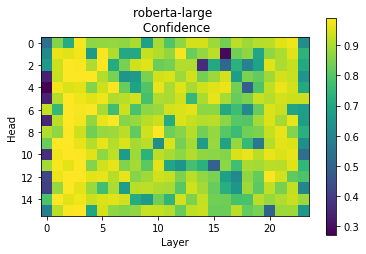

In [9]:
plt.title(f"{args.model_name_or_path} \n Confidence")
plt.xlabel("Layer")
plt.ylabel("Head")
plt.imshow(np.array(all_attentions.T.tolist()))
plt.colorbar()
#plt.savefig(f"{args.model_name_or_path}_confidence.png", bbox_inches="tight")

In [10]:
(np.array(all_answers) == np.array(all_preds)).mean()

0.28

In [35]:
tokenizer.encode("smaller", add_special_tokens=False)

[23115, 254]

In [37]:
tokenizer.decode(254)

'er'

In [9]:
a = 0
b = 0
for i in range(len(all_answers)):
    if all_preds[i] != -1:
        b += 1
        if all_preds[i] == all_answers[i]:
            a += 1

In [10]:
a/b

0.47345132743362833

In [11]:
b/len(all_answers)

0.7545909849749582

In [52]:
plt.scatter(first_age, second_age, c=all_preds, marker="s")
plt.title(f"Age Comparison {args.model_name_or_path}")
plt.axis("square")
plt.xlabel("Age 1")
plt.ylabel("Age 2")
#plt.savefig(f"imgs/{args.model_name_or_path.rsplit('/', 1)[-1]}-ages-double.jpg", bbox_inches="tight")
plt.show()

NameError: name 'first_age' is not defined

In [107]:
embeds = np.empty((80, 1024))
for age in range(20, 80):
    #input_id = tokenizer.encode(f" {age}", add_special_tokens=False)
    input_id = tokenizer.encode(f"{age}", add_special_tokens=False)
    assert len(input_id) == 1
    #embeds[age - 20] = model.roberta.embeddings.word_embeddings(torch.tensor(input_id)).detach()
    embeds[age - 20] = model.bert.embeddings.word_embeddings(torch.tensor(input_id)).detach()
    
random_words = ["dismissal", "leader", "relaxation", "Bible", "survivor", "swim", "contradiction", "complain", "inquiry", "lion", "world", "cigarette", "doctor", "emphasis", "motorcycle", "democratic", "welfare", "conventional", "die", "gas"]
for i, word in enumerate(random_words):
    #input_id = tokenizer.encode(f" {word}", add_special_tokens=False)
    input_id = tokenizer.encode(f"{word}", add_special_tokens=False)
    assert len(input_id) == 1
    #embeds[60 + i] = model.roberta.embeddings.word_embeddings(torch.tensor(input_id)).detach()
    embeds[60 + i] = model.bert.embeddings.word_embeddings(torch.tensor(input_id)).detach()

In [108]:
embeds

array([[-0.01035529,  0.03517554,  0.00320891, ..., -0.02663885,
         0.00429494, -0.01093527],
       [ 0.00719996,  0.05101202,  0.01818159, ..., -0.03738092,
         0.02962709, -0.02694976],
       [ 0.01124011,  0.02021734,  0.01298556, ..., -0.06276181,
         0.01202204,  0.00210404],
       ...,
       [-0.03775964,  0.0051798 ,  0.03141473, ..., -0.04463494,
        -0.02556634,  0.07584442],
       [-0.05155059, -0.02718926,  0.01952895, ...,  0.01727759,
         0.01854797,  0.03472063],
       [-0.00671914, -0.01403439, -0.04678096, ..., -0.06022274,
        -0.00647926, -0.02847613]])

In [25]:
from sklearn.decomposition import PCA

In [109]:
pca = PCA(n_components=2)

In [110]:
mapped_embeds = pca.fit_transform(embeds)

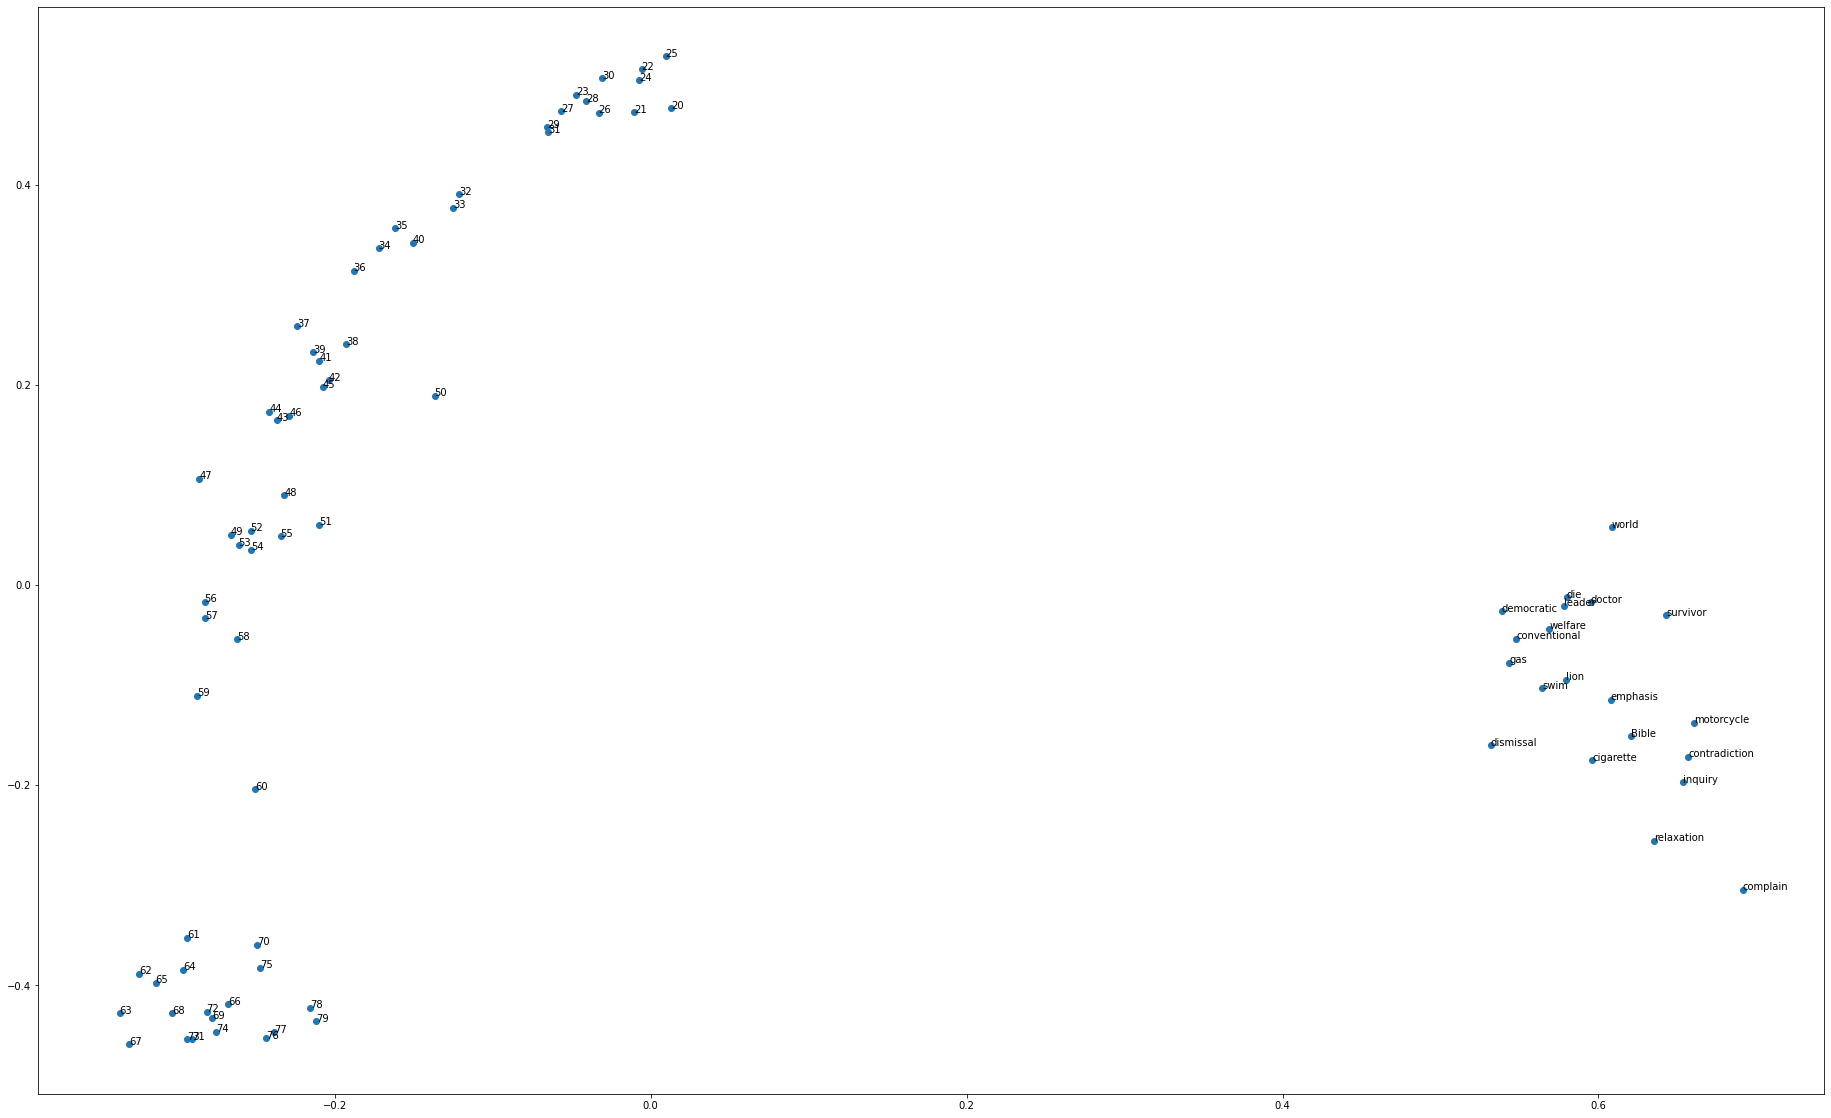

In [112]:
fig, ax = plt.subplots(figsize=(32,20))
ax.scatter(mapped_embeds[:, 0], mapped_embeds[:, 1])

for i in range(20, 80):
    ax.annotate(i, tuple(mapped_embeds[i-20]))
    
for i in range(60, 80):
    ax.annotate(random_words[i-60], tuple(mapped_embeds[i]))
    
plt.savefig("20-30_Vis/pca-bert.png")

In [62]:
from sklearn.manifold import TSNE

In [126]:
tsne_embeds = TSNE(n_components=2, perplexity=15).fit_transform(embeds) # perplexity=15

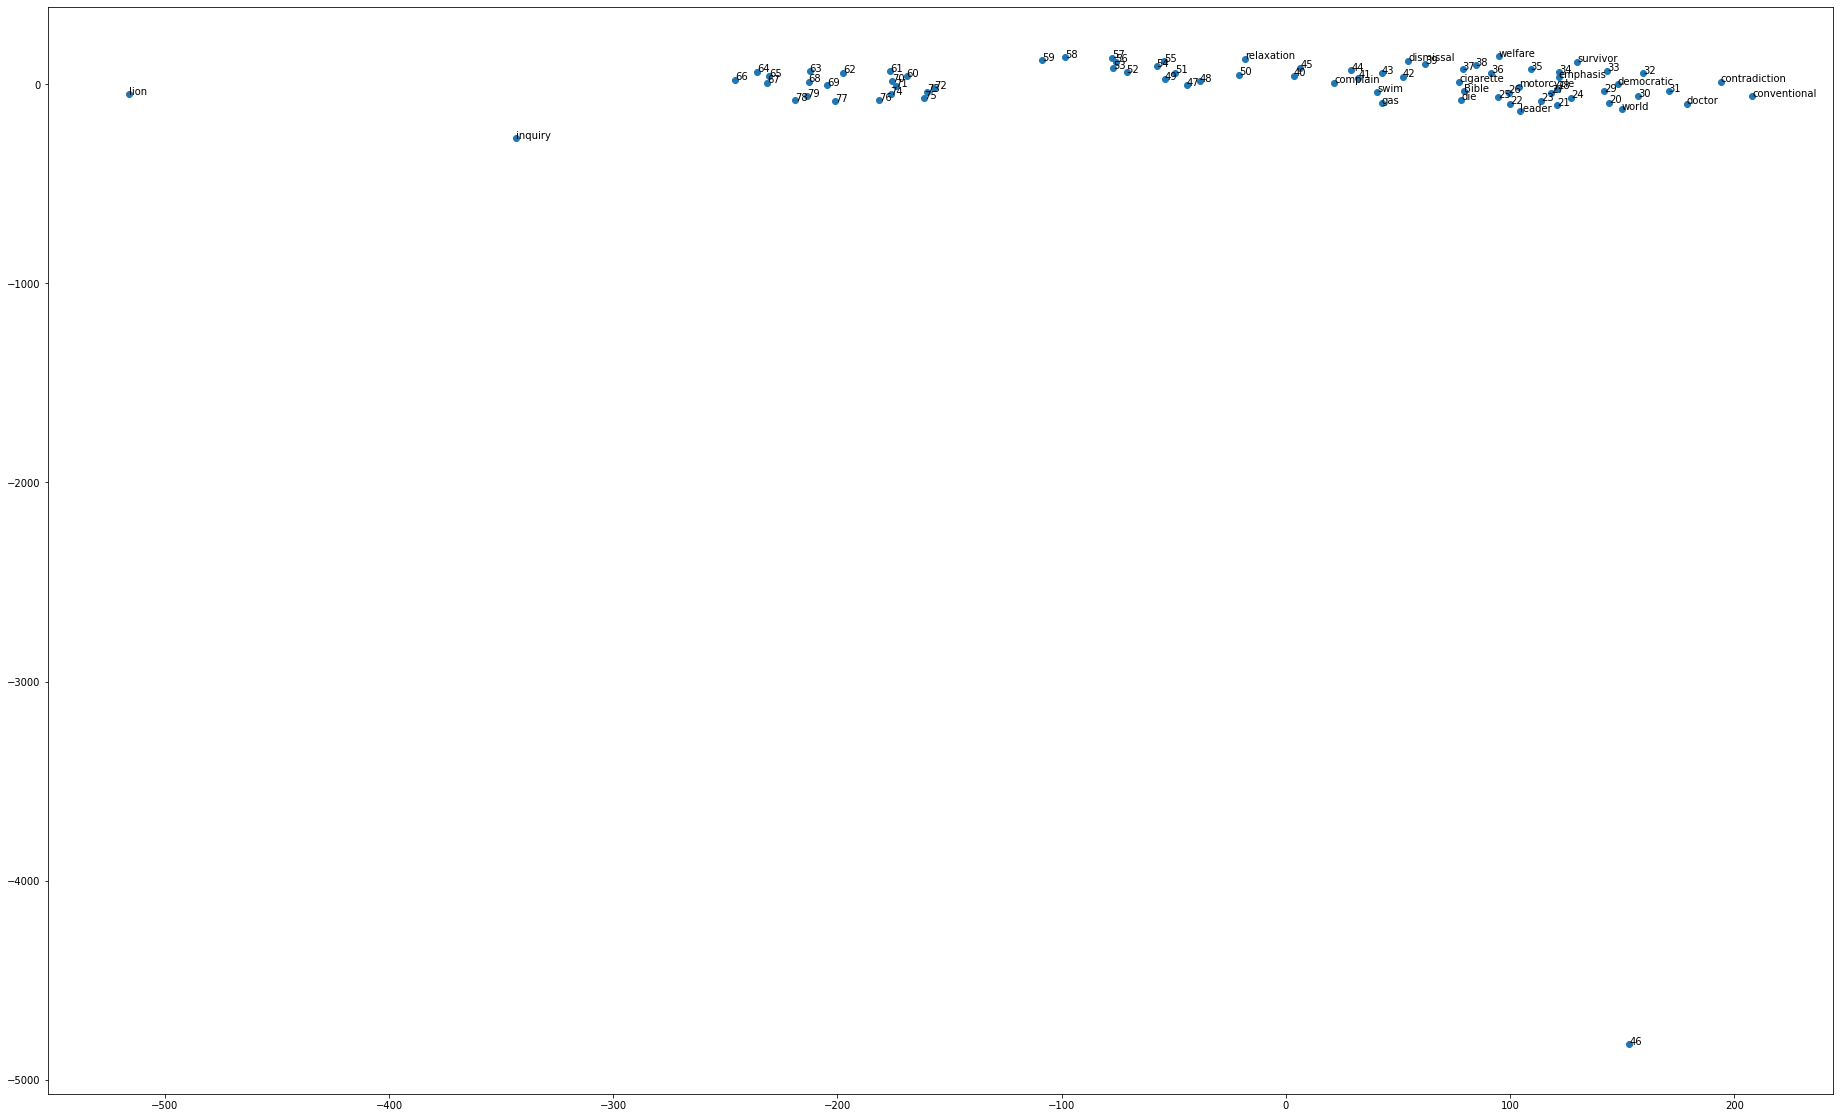

In [127]:
fig, ax = plt.subplots(figsize=(32,20))
ax.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1])

for i in range(20, 80):
    ax.annotate(i, tuple(tsne_embeds[i-20]))
    
for i in range(60, 80):
    ax.annotate(random_words[i-60], tuple(tsne_embeds[i]))
    
#plt.plot([-20, 100], [40, -35], c="red")
#plt.savefig("20-30_Vis/tsne2.png")